<a href="https://colab.research.google.com/github/RuthKassahun/Melanoma_Classification/blob/main/big_transfer_MultiClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

Below are all the imports used in the **Notebook**.

In [1]:
# Common
import os
import numpy as np 
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow_hub as hub
from IPython.display import clear_output as cls

# Data 
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Model 
from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout

# Callbacks 
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Pre-Trained Model
from tensorflow.keras.applications import ResNet50V2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Info**

Before **loading the data**, let's have a look at the **class distribution**.

In [3]:
# Class Names
root_path = '/content/drive/MyDrive/MultiClass_Skin_lesion/train/'
class_names = sorted(os.listdir(root_path))
n_classes = len(class_names)

# Class Distribution
class_dis = [len(os.listdir(root_path + name)) for name in class_names]


# Show
print(f"Total Number of Classes : {n_classes} \nClass Names : {class_names}")

Total Number of Classes : 3 
Class Names : ['bcc', 'mel', 'scc']


Let's look at the **Class Distribution** of the **Training Dataset**.

In [5]:
# Visualize 
fig = px.pie(names=class_names, values=class_dis, title="Training Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.48}})
fig.show()

In [6]:
# Visualize 
fig = px.bar(x=class_names, y=class_dis, title="Training Class Distribution", color=class_names)
fig.update_layout({'title':{'x':0.48}})
fig.show()

So in total, there are **5 x 1,500 = 7,500** images. These **classes are equally distributed** to ensure a **perfect representation for each class**.

In [4]:
# Class Names
valid_path = '/content/drive/MyDrive/MultiClass_Skin_lesion/val/'

# Class Distribution
class_dis = [len(os.listdir(valid_path + name)) for name in class_names]

# Pie
fig = px.pie(names=class_names, values=class_dis, title="Validation Class Distribution", color=class_names, hole=0.2)
fig.update_layout({'title':{'x':0.5}})
fig.show()

# Visualize 
fig = px.bar(x=class_names, y=class_dis, color=class_names)
fig.show()

Each class has **500 images** for **validation purpose**, this should be sufficient for **evaluating the model**.

In [ ]:
# Class Names
test_path = '/content/drive/MyDrive/MultiClass_Skin_lesion/testX/'

# Class Distribution
class_dis = [len(os.listdir(test_path + name)) for name in class_names]

# Pie
fig = px.pie(names=class_names, values=class_dis, title="Testing Class Distribution", color=class_names, hole=0.2)
fig.update_layout({'title':{'x':0.48}})
fig.show()

# Visualize 
fig = px.bar(x=class_names, y=class_dis, color=class_names)
fig.show()

# **Data Loading**

It's time to **load the Training Data, Validation Data and Testing Data**, we **will load the data** using **Image Data Geneartor**.

In [5]:
# Initialize Generator
train_gen = ImageDataGenerator(rescale=1/255., rotation_range=10, horizontal_flip=True)
valid_gen = ImageDataGenerator(rescale=1/255.)
#test_gen = ImageDataGenerator(rescale=1/255)

# Load Data
train_ds = train_gen.flow_from_directory(root_path, class_mode='binary', target_size=(256,256), shuffle=True, batch_size=32) 
valid_ds = valid_gen.flow_from_directory(valid_path, class_mode='binary', target_size=(256,256), shuffle=True, batch_size=32) 
#test_ds = test_gen.flow_from_directory(test_path, class_mode='binary', target_size=(256,256), shuffle=True, batch_size=32)

Found 5082 images belonging to 3 classes.
Found 1270 images belonging to 3 classes.


# **Data Visualization**

The **best way to understand** the data is to **visualize it**. All the images present in the **Training, Validation, Testing and Interesting images** have something unique in them.

In [6]:
def show_images(GRID=[5,5], model=None, size=(20,20), data=train_ds):
    n_rows = GRID[0]
    n_cols = GRID[1]
    n_images = n_cols * n_rows
    
    i = 1
    plt.figure(figsize=size)
    for images, labels in data:
        id = np.random.randint(len(images))
        image, label = images[id], class_names[int(labels[id])]
        
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        
        if model is None:
            title = f"Class : {label}"
        else:
            pred = class_names[int(np.argmax(model.predict(image[np.newaxis, ...])))]
            title = f"Org : {label}, Pred : {pred}"
            cls()
        
        plt.title(title)
        plt.axis('off')
        
        i+=1
        if i>=(n_images+1):
            break
            
    plt.tight_layout()
    plt.show()

In [7]:
def load_image(path):
    '''This function will load the image present at the given location'''
    image = tf.cast(tf.image.resize(img_to_array(load_img(path))/255., (256,256)), tf.float32)
    return image
def show_image(image, title=None):
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)

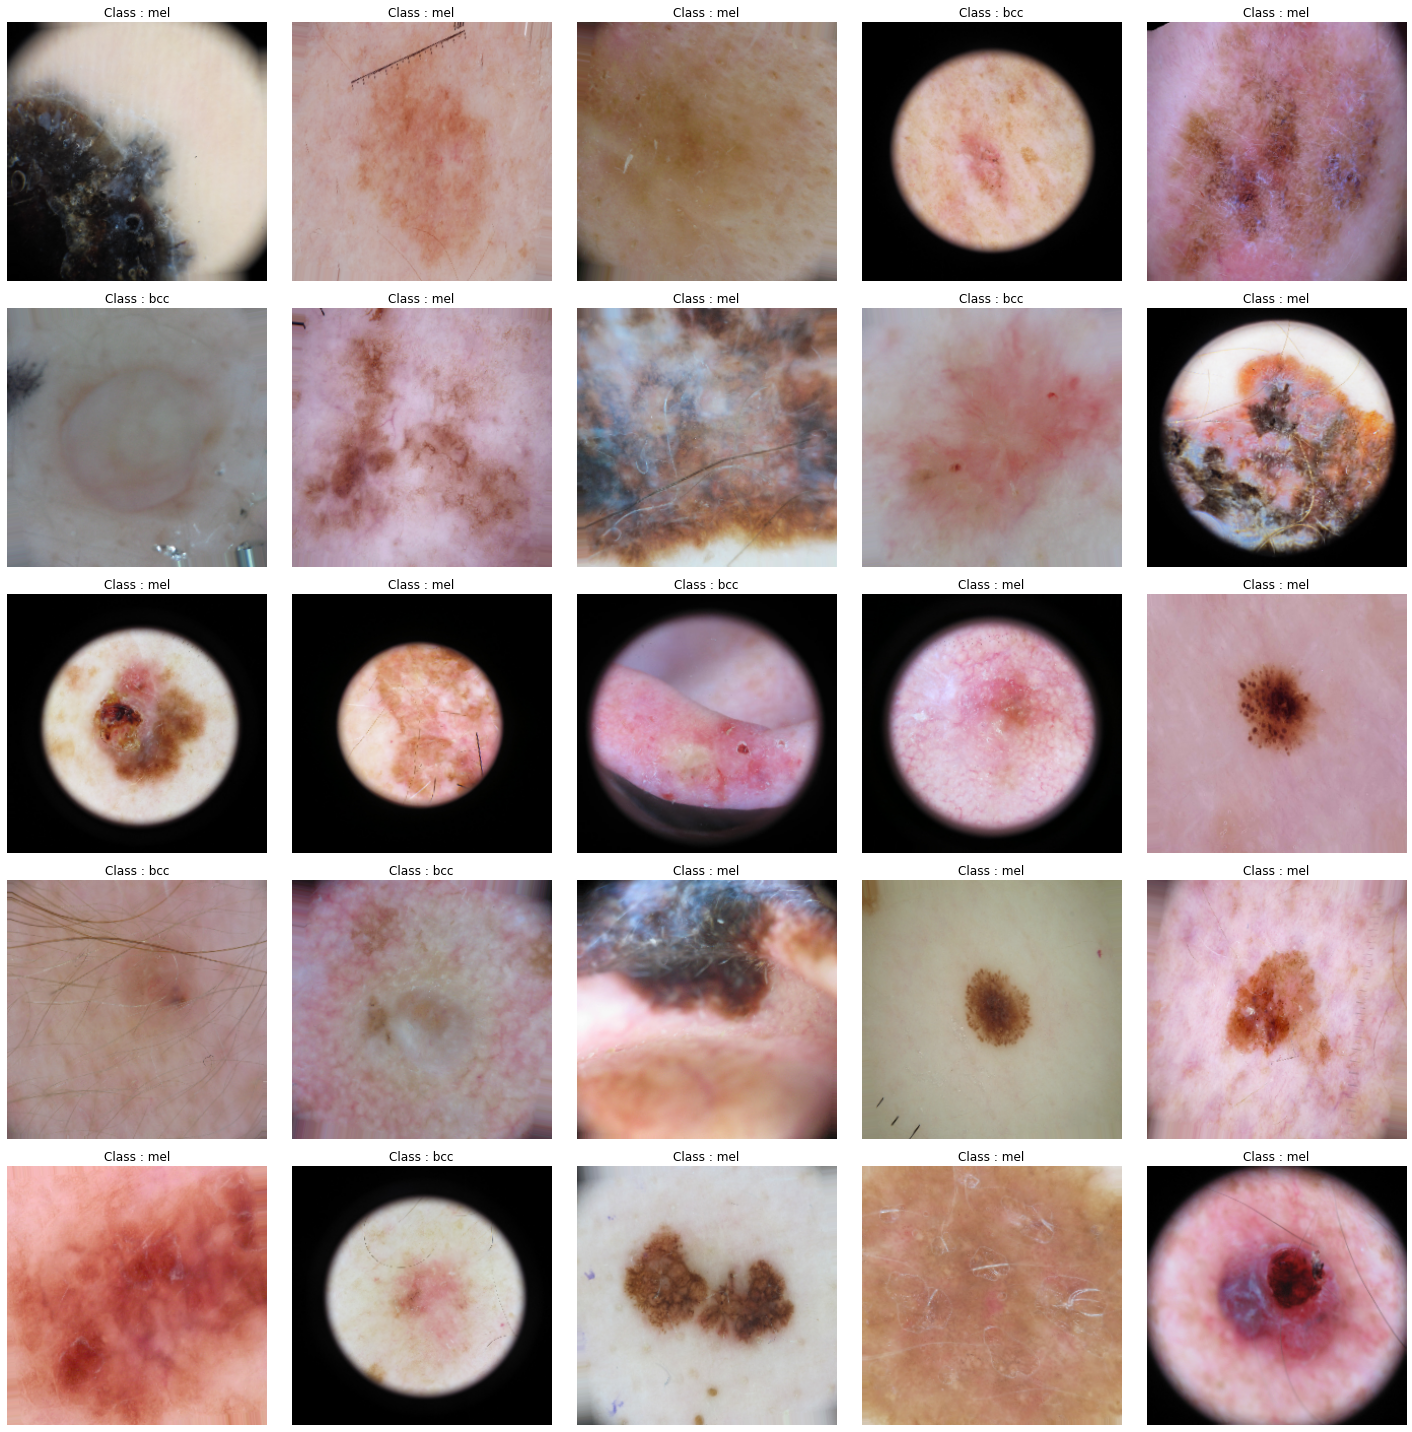

In [12]:
show_images(data=train_ds)

**Training data** is made in such a way that the **model** will be **able to extract all the necessary information**.

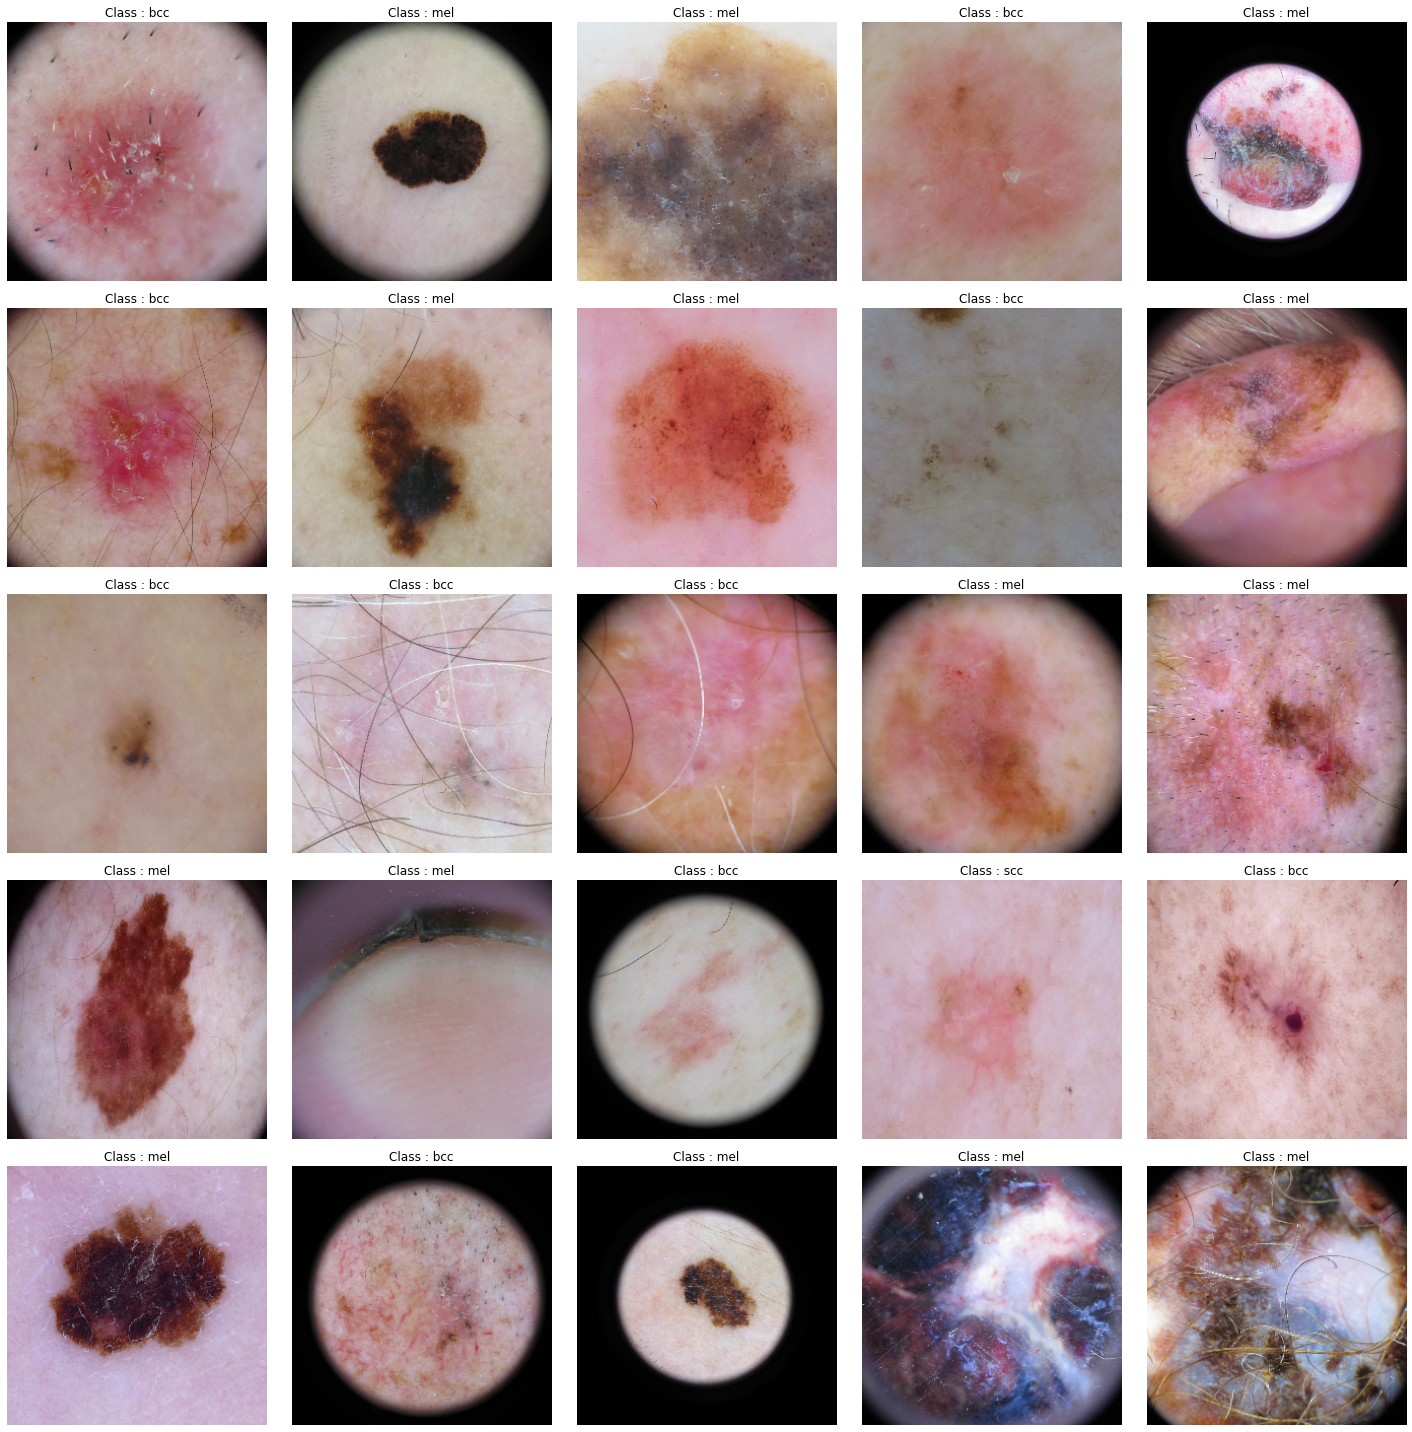

In [13]:
show_images(data=valid_ds)

This is the **Validation Data**, this have **some unique images** which will **test model's ability to it's limits**.

# **Big Transfer - BiT**

From architecture perspective **BiT** is nothing but a **4x times Scaled version** of **ResNet152V2**. The main idea here is of **Transfer Learning** this model is **pre-trained** on a **Large Dataset**, so it can be **trained on sub-datasets** or basically **other small datasets** and as the model is pre-trained on a **Very large Dataset** it is expected that it will **perform amazingly well** on the **small dataset**. There are **3 variants of BiT :**

* **BiT-L** : This is trained on **Image Classification** task of **300M Samples**(This is Private).
* **BiT-M** : This is trained on **Image Classification** task of **14M Samples**.
* **BiT-S** : This is trained on **Image Classification** task of **1.3M Samples**.

Load the **BiT-M** Model.

In [8]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)

## **Create BiT**

The base of our model is **BiT** but we need to add a **Head this base model**.

In [9]:
model = Sequential([
    bit_module,
    Dense(n_classes, activation='softmax', kernel_initializer='zeros')
], name='bit-custom')

## **Define Optimizer**

In [10]:
BATCH_SIZE = 32
lr = 1e-3 * BATCH_SIZE/512
print(f"Learning rate : {lr}")

Learning rate : 6.25e-05


In [11]:
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]  # more the dataset size the schedule length increase

In [12]:
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        lr,
        lr * 0.1,
        lr * 0.01,
        lr * 0.001,
    ],
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

## **Compile Model**

In [13]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

## **Callbacks**

In [14]:
cbs = [EarlyStopping(patience=5, restore_best_weights=True), ModelCheckpoint('bit-custom.h5', save_best_only=True)]

## **Model Training**

In [15]:
history = model.fit(train_ds, validation_data=valid_ds, epochs=20, callbacks=cbs)

Epoch 1/20
159/159 [==============================] - 1589s 10s/step - loss: 0.6244 - accuracy: 0.7410 - val_loss: 0.5680 - val_accuracy: 0.7654
Epoch 2/20
159/159 [==============================] - 194s 1s/step - loss: 0.5138 - accuracy: 0.7956 - val_loss: 0.5110 - val_accuracy: 0.7984
Epoch 3/20
159/159 [==============================] - 191s 1s/step - loss: 0.4938 - accuracy: 0.8109 - val_loss: 0.5029 - val_accuracy: 0.8087
Epoch 4/20
159/159 [==============================] - 192s 1s/step - loss: 0.4922 - accuracy: 0.8097 - val_loss: 0.5029 - val_accuracy: 0.8094
Epoch 5/20
159/159 [==============================] - 190s 1s/step - loss: 0.4920 - accuracy: 0.8085 - val_loss: 0.5028 - val_accuracy: 0.8094
Epoch 6/20
159/159 [==============================] - 188s 1s/step - loss: 0.4929 - accuracy: 0.8099 - val_loss: 0.5028 - val_accuracy: 0.8094
Epoch 7/20
159/159 [==============================] - 190s 1s/step - loss: 0.4916 - accuracy: 0.8117 - val_loss: 0.5028 - val_accuracy: 0.80

# **Learning Curve**

In [ ]:
# pd.DataFrame(history.history).plot(figsize=(8,5))
# plt.grid()
# plt.show()

![image.png](attachment:bf7f396e-c6ae-483a-92d7-fa628c6a98ae.png)

# **Evaluation**

In [ ]:
#model = load_model('/content/bit-custom.h5', custom_objects={'KerasLayer':bit_module})

In [16]:
model.evaluate(valid_ds)

40/40 [==============================] - 28s 698ms/step - loss: 0.5020 - accuracy: 0.8102


[0.5019562244415283, 0.8102362155914307]

In [17]:
prediction = model.predict(valid_ds)

40/40 [==============================] - 28s 662ms/step


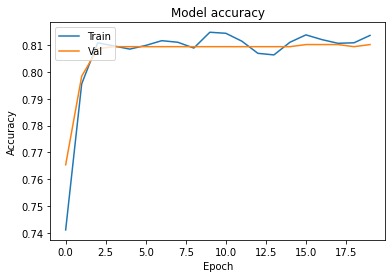

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

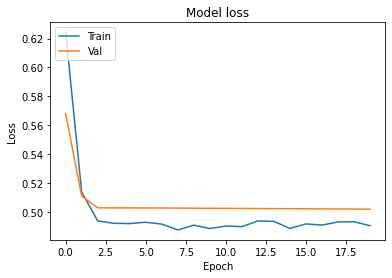

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
y_pred = np.argmax(prediction, axis=1)

In [ ]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_pred,test_labels_encoded )
print(kappa)